<a href="https://colab.research.google.com/github/PiratheepanGajan/PiratheepanGajan.github.io/blob/main/ME421_ControlSystems_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions

* This is a group assignment. Complete the activities in groups that were assigned for ME421 for the vibrations lab.

* Make a copy of this and save it in your group github group repository.

* Do all your work, EXCLUSIVELY, in that saved notebook. Your github commits will serve as a refelection of your individual contributions. It will constitute 25% of your final grade for the lab.

* Complete Tasks#1 and Task#2 by 5:00PM on 18/01/2024

* Complete Tasks#3 and the Task#4 by 5:00PM on 25/01/2024 and demonstrate the work in the class on 01/02/2024.

* Complete Task#5 by 5:00PM on 08/02/2024 and submit the link to your working repository by midnight 08/02/2024.

#References

* https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/Mugas_Rigid_Body_Control.ipynb

* https://github.com/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/MaithriPalaDHS_RigidBodyPIDControl_IITB_18_03_2023.pdf

In [22]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import math
from numpy import linalg
import sympy

from sympy import symbols
from sympy import *

import plotly.graph_objects as go
import plotly.express as px

In [23]:
class mugas_rigid_body_functions:

  def __init__(self):
    self=[];

  def simulateDySystem(self, dynamicSystemModel, Tmax, dT, X0, sysPara, figTitle, xLabel, yLabel):
    t = np.linspace(0, Tmax, int(Tmax/dT+1))
    sol = odeint(dynamicSystemModel, X0, t, args=(sysPara,));
    self.soln=sol;
    fig = go.Figure()
    [nt,nS]=sol.shape;

    # Add traces
    for nn in range(nS):
      fig.add_trace(go.Scatter(x=t, y=sol[:,nn], mode='lines+markers', name='x'+str(nn+1)))
      fig.update_layout(title=figTitle, xaxis=dict(title=xLabel),yaxis=dict(title=yLabel))

    fig.show()
    return [t,sol,fig]

  def hatMatrix(self, X):
    return np.array([[0., -X[2], X[1]],[X[2], 0., -X[0]],[-X[1], X[0], 0.]])

  def qFromAxisAngles(self, theta, unitAxis):
    return np.concatenate(([np.cos(theta/2)],np.sin(theta/2)*np.array(unitAxis)))

  def RfromQuaternions(self,q):
    q0=q[0]; w=q[1:];
    R=np.identity(3)+2*q0*self.hatMatrix(w)+2*self.hatMatrix(w) @ self.hatMatrix(w);
    return R

  def rotationMatrix2EulerAngles(self,R):
    if R[2,2] <1:
      if R[2,2] > -1:
        theta2=math.acos(R[2,2]);
        theta1=math.atan2(R[0,2],R[1,2]);
        theta3=math.atan2(R[2,0],-R[2,1]);
      else: #R[2,2]=-1 No Unique solution
        theta2=np.pi;
        theta1=-math.atan2(R[0,1],-R[0,0]);
        theta3=0;
    else: # R[2,2] = +1 No Unique solution
      theta2 = 0;
      theta1 = math.atan2(R[0,1],R[0,0]) ;
      theta3 = 0;
    return [np.pi-theta1,theta2,np.pi-theta3]


  def rotate_and_translate(self,objectVertices,R,b):
    #object vertices should be given as an numpy array of shape (3,n)
    #Ex - X=[0, 0, 2, 2, 0, 0, 2, 2], Y=[0, 2, 2, 0, 0, 2, 2, 0], Z=[0, 0, 0, 0, 1, 1, 1, 1]; objectVertices=[X,Y,Z]
    return np.array([[b[0],b[1],b[2]]]).T + R @ objectVertices


  def addOrthNormFrame(self, fig, o, R, axisRange, axisColor):
    e1=[1,0,0]; e2=[0,1,0]; e3=[0,0,1];
    b1=R @ e1; b2=R @ e2; b3=R @ e3;
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b1[0])], y=[str(o[1]),str(o[1]+b1[1])], z=[str(o[2]),str(o[2]+b1[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b2[0])], y=[str(o[1]),str(o[1]+b2[1])], z=[str(o[2]),str(o[2]+b2[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b3[0])], y=[str(o[1]),str(o[1]+b3[1])], z=[str(o[2]),str(o[2]+b3[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.update_layout(showlegend=False, scene=dict(xaxis=dict(range=axisRange[0], autorange=False), yaxis=dict(range=axisRange[1], autorange=False), zaxis=dict(range=axisRange[2], autorange=False), aspectratio=dict(x=1, y=1, z=1)))
    return fig

  def cube_vertices(self,cubeDimensions):
    l=cubeDimensions['l']; w=cubeDimensions['w']; h=cubeDimensions['h'];
    xp=cubeDimensions['xp']; yp=cubeDimensions['yp']; zp=cubeDimensions['zp'];
    #X=[0, 0, l, l, 0, 0, l, l]; Y=[0, w, w, 0, 0, w, w, 0]; Z=[0, 0, 0, 0, h, h, h, h]; XX=[X,Y,Z];
    X=[-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]; Y=[-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]; Z=[-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]; XX=[X,Y,Z];
    #X=[-l, -l, l, l, -l, -l, l, l]; Y=[-w, w, w, -w, -w, w, w, -w]; Z=[-h, -h, -h, -h, h, h, h, h]; XX=[X,Y,Z];
    return XX


  def animate_particle_motion(self, XX, axisRange, figTitle):
    xx=[jj[0] for jj in XX]
    yy=[jj[1] for jj in XX]
    zz=[jj[2] for jj in XX]

    fig = go.Figure(
        data=[go.Scatter3d(x=[xx[0]], y=[yy[0]],z=[zz[0]],
                        mode="markers",
                        marker=dict(color="red", size=10)),
              go.Scatter3d(x=xx, y=yy,z=zz, name='Path',
                        mode="lines",
                        line=dict(color="blue", width=2))],
        layout=go.Layout(
            scene = dict(
                        xaxis=dict(range=axisRange[0], autorange=False),
                        yaxis=dict(range=axisRange[1], autorange=False),
                        zaxis=dict(range=axisRange[2], autorange=False),
                        aspectratio=dict(x=1, y=1, z=1),
            ),
            title_text=figTitle, hovermode="closest",
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]),
        frames=[go.Frame(
            data=[go.Scatter3d(
                x=[p[0]],
                y=[p[1]],
                z=[p[2]],
                name='Particle',
                mode="markers",
                marker=dict(color="red", size=10))])

            for p in XX]
    )

    fig.show()
    return fig

  def animated_cube_flat_shading(self, cubeVertices, figTitle):
    fig = go.Figure(
        frames=[go.Frame(data=[
          go.Mesh3d(
            # 8 vertices of a cube
            x=xx[0][0],
            y=xx[0][1],
            z=xx[0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)]) for xx in cubeVertices])

    fig.add_trace(go.Mesh3d(
            # 8 vertices of a cube
            x=cubeVertices[0][0][0],
            y=cubeVertices[0][0][1],
            z=cubeVertices[0][0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)
        )
    duration=10;
    fig.update_layout(
          title=figTitle,
          width=600,
          height=600,
          scene=dict(
                      xaxis=dict(range=[-5., 5.], autorange=False),
                      yaxis=dict(range=[-5., 5.], autorange=False),
                      zaxis=dict(range=[-5., 5.], autorange=False),
                      aspectratio=dict(x=1, y=1, z=1),
                      ),
          updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None, {"frame": {"duration": duration},"mode": "immediate","fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}]
                                            )])])
    len(fig.frames)
    fig.show()
    return fig


  def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
    XX=self.cube_vertices(cubeDimensions);

    #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
    Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);

    ICR=ICs[0][0];
    XX0=ICR @ XX;

    rotatedVertices=[[XX0]]
    for X in Xs:
      #print(X[0])
      R=X[0][0];
      o=X[0][1];
      XXi=self.rotate_and_translate(XX,R,o);
      XX0=XXi;
      rotatedVertices+=[[XX0]];
    return rotatedVertices


  def eulers_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      [taue,fe]=externalForceModel(self, parameters,X);
      [taua,fa]=actuator(self, parameters, t, X,taue,fe);

      dspi=taue+taua;
      dp=fe+fa;
      dXc=controller_dynamics(self, t,X,taue,fe,parameters)

      if linalg.norm(omega)>=0.0001:
        nomega=omega/linalg.norm(omega);
        thetaomegat=dt*linalg.norm(omega);
      else:
        nomega=np.array([0,0,0]);
        thetaomegat=0;
      qomegat=np.concatenate(([np.cos(thetaomegat/2)],np.sin(thetaomegat/2)*nomega));
      R=self.RfromQuaternions(qomegat) @ R;
      o=o+dt*doto;
      spi=spi+dt*dspi;
      p=p+dt*dp;
      doto=p/M;
      omega=R @ invII @ R.T @ spi;
      Xc=Xc+dt*dXc;
      X=[[R,o],omega,doto, Xc];
      Xout+=[X]

    return Xout

  def runga_kutta_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    X=ICs;
    Xout=[X];
    for t in timeSteps:
      Y1=self.rk4_function(0.5*dt, X, t, X, parameters);
      Y2=self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters);
      Y3=self.rk4_function(dt, X, t+0.5*dt, Y2, parameters);

      [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, t, X);
      [thetaomega2,nomega2,doto2,dp2,dspi2,dXc2]=self.rigid_body_system(parameters, t+0.5*dt, Y1);
      [thetaomega3,nomega3,doto3,dp3,dspi3,dXc3]=self.rigid_body_system(parameters, t+0.5*dt, Y2);
      [thetaomega4,nomega4,doto4,dp4,dspi4,dXc4]=self.rigid_body_system(parameters, t+dt, Y3);

      omegak=(dt/6.0)*(thetaomega1*nomega1+2*thetaomega2*nomega2+2*thetaomega3*nomega3+thetaomega4*nomega4)
      if linalg.norm(omegak)>=0.0001:
        nomegak=omegak/linalg.norm(omegak);
        thetaomegak=linalg.norm(omegak);
      else:
        nomegak=np.array([0,0,0]);
        thetaomegak=0;
      qomegak=np.concatenate(([np.cos(thetaomegak/2)],np.sin(thetaomegak/2)*nomegak));
      Rk=self.RfromQuaternions(qomegak) @ X[0][0];

      dotok=(1./6.0)*(doto1+2*doto2+2*doto3+doto4);
      dpk=(1./6.0)*(dp1+2*dp2+2*dp3+dp4);
      dspik=(1./6.0)*(dspi1+2*dspi2+2*dspi3+dspi4);
      dXck=(1./6.0)*(dXc1+2*dXc2+2*dXc3+dXc4);

      ok=X[0][1]+dt*dotok;
      pk=X[2]+dt*dpk;
      spik=X[0][0]@II@X[0][0].T@X[1]+dt*dspik;
      Xck=X[3]+dt*dXck;
      omegak=Rk @ linalg.inv(II) @ Rk.T @ spik;
      X=[[Rk,ok],omegak,pk,Xck];
      Xout+=[X]
    return Xout

  def rk4_function(self, dtk, X, tk, Xk, parameters):
    M=parameters['M']; II=parameters['II'];
    [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, tk, Xk)
    qomega1=np.concatenate(([np.cos(dtk*thetaomega1/2)],np.sin(dtk*thetaomega1/2)*nomega1));
    R1=self.RfromQuaternions(qomega1)@X[0][0];
    p1=X[2]+dtk*dp1;
    spi1=X[0][0]@II@X[0][0].T@X[1]+dtk*dspi1; omega1=R1@linalg.inv(parameters['II'])@R1.T@spi1;
    X1=[[R1, X[0][1]+dtk*doto1],omega1,p1, X[3]+dtk*dXc1]
    return X1

  def rigid_body_system(self, parameters, t, X):
    barX=parameters['CM']; M=parameters['M'];
    R=X[0][0]; omega=X[1]; p=X[2];

    [taue,fe]=externalForceModel(self, parameters,X);
    [taua,fa]=actuator(self, parameters, t, X,taue,fe);

    doto=p/M;
    dp=fe+fa;
    dspi=taue+taua;
    dXc=controller_dynamics(self, t,X,taue,fe,parameters);
    if linalg.norm(omega)>=0.0001:
      nomega=omega/linalg.norm(omega);
      thetaomega=linalg.norm(omega);
    else:
      nomega=np.array([0,0,0]);
      thetaomega=0;
    return [thetaomega,nomega,doto,dp,dspi,dXc]

In [24]:
def LinearSystemModel(X, t, A):
  dXdt=A @ X;
  return dXdt

In [25]:
def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=qq.RfromQuaternions(qOmegart);
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI)
  fu=-fe+np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  #print(eR)
  return dXc

In [26]:
mr=MugasRigidBodyFunctions()

#Task#1

Conside a rigid body moving in space. Let $\mathbf{b}$ be a body fixed frame with the origin coinciding with that of the center of mass of the body, $M$ be the tatal mass of the body, $\mathbb{I}$ be the inertia tensor of the body with respect to the body frame $\mathbf{b}$, $f^e$ be the resultant total external interactions acting on the particles of the body, and $\tau^e$ be the total resultant of the moments of the external interactions about the center of mass of the body.

Show that a general rigid body is descibed by the following simple equations in an inertial frame $\mathbf{e}$ where the moments are taken about the center of mass of the rigid body.

\begin{align}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e+f^u,\\
\dot{\pi}&=\tau^e+\tau^u,
\end{align}
where
\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align}
Here we have split the force and control moments into unmanipulatable and manipulatable (control) part. The manipulatable (control) part will be denoted by a superscript $u$.

Let the inertial frame with the origin $O$ be $e$ and body frame be b(t) and let $O'$ be the origin of the frame $b$. \\
Let, $OO' = eo(t)$. By using the Rotational matrix $R(t)$ we can uniquely relate the body frame $b$ with $e$ as, \\
$b(t) = eR(t)$ \\
and the position of the origin $o(t)$ in $o \in \mathbb{R}^3$, and $R$ $ \in SO(3)$ defines the configuration that is unique to the body by using a special $3 \times 3$ matrix. But, we can also define this $(o,R) \in \mathbb{R}^3 \times SO(3)$ with a unique $4 \times 4$ matrix $E$ which will be an special euclidean representation as,
\begin{align}
E = \begin{bmatrix} R & o \\ 0 & 1\end{bmatrix}
\end{align} \\
We denote these type of special space matrices as $SE(3)$ \\
In the previous session we did we declared a special matrix $\Omega$ which had the following relationship,
\begin{align}
\widehat{\Omega}=R^T\dot{R} & &-> (1)
\end{align} \\

Where, $\Omega$ will reresent the body angular velocity of the rigid body with an magnitude of $||\Omega||$ around the axis of $\Omega$ in the body frame $b$ for an instantaneous rotation. This same quantity can be repsrented in the $e$ frame as,
\begin{align}
\omega=R\Omega
\end{align}
therefor, we can obtain,
\begin{align}
R^T\omega=\Omega
\end{align}
Where, $R$ rotation matrix relates the frames $e$ and $b$. From the above equation we can relate to $\widehat{\Omega}$
\begin{align}
\widehat{\Omega} &= \widehat{R^T\omega} \\
\widehat{\Omega} &= R^T\widehat{\omega}R  & &-> (2)
\end{align}
From the equation $1$,
\begin{align}
R^T\widehat{\omega}R &= R^T\dot{R} \\
\widehat{\omega}R &= \dot{R}
\end{align}


---




The total linear momentum of a set of particales can be represented as,
\begin{align}
p &= \sum_i p_i \\
p &= \sum_i m_i(\dot{o} + R(\widehat{\Omega}X_i + \dot{X}_i))
\end{align} \\
For rigid bodies, $\dot{X}_i = 0_{3\times1}$, therefor,
\begin{align}
p &= \sum_i m_i(\dot{o} + R\widehat{\Omega}X_i) \\
p &= \sum_i m_i\frac{X_i}{X_i}(\dot{o} + R\widehat{\Omega}X_i) \\
p &= M(\dot{o} + R\widehat{\Omega}\bar{X})
\end{align}
From $2$
\begin{align}
p &= M(\dot{o} + \widehat{\omega}R\bar{X})&-> (3) \\
p &= M\dot{\bar{x}}
\end{align} \\
where, $M$ is obtained from the total moment of the particles
\begin{align}
M &= \sum_i m_i\bar{X} \\
M &= \frac{\sum_i m_i{X_i}}{\sum_i m_i}
\end{align} \\
From 3 we can derive for $\dot{o}$ that,
\begin{align}
\dot{o} &= \frac{1}{M}p - \widehat{\omega}R\bar{X} \\
\dot{o} &= \frac{1}{M}p - {\omega}\times R\bar{X}
\end{align} \\
But as the origin of the frame $b$ is coincinding with the center of mass of the body $\bar{X}=0_{3 \times 1}$. Thus,
\begin{align}
\dot{o} &= \frac{1}{M}p
\end{align}


---



From previous practices we know that angular momentum $\pi_i$ of a point like particle of mass $m_i$ about the origin $O'$ in the frame $b$ can be written as,
\begin{align}
\pi_i &=R(\mathbb{I}_i\Omega + m_iX_i \times (R^T\dot{o} + \dot{X}_i))
\end{align} \\
This can be represented in the frame $e$ by the removing the relationship with the $R$ as,
\begin{align}
\Pi_i &=(\mathbb{I}_i\Omega + m_iX_i \times (R^T\dot{o} + \dot{X}_i))
\end{align} \\
where, the moment of inertia of the particle is defined by the $\mathbb{I}_i$ abount the point $O'$ in the frame $b$ as,
\begin{align}
\mathbb{I}_i &= -m_i\widehat{X}^2_i \\
\mathbb{I}_i &= m_i(||X_i||^2I_{3\times3} - X_iX_i^T)
\end{align} \\
As for rigid bdoeis the partices fixed to the with respect to frame $b$, $\dot{X}_i=0_{3\times1}$ and From the above 2 relations for the angular momentum, we can see the following relationship among them in 2 frames,
\begin{align}
\pi_i = R\Pi_i
\end{align}
Thus giving us,
\begin{align}
\pi &= \sum_i \pi \\
\pi &= \sum_i R\Pi_i \\
\pi &=  R\Pi
\end{align}


---



From the $p=M\dot{\bar{x}} = M(\dot{o} + R\widehat{\Omega}\bar{X}) = M(\dot{o} + R({\Omega}\times \bar{X})$ we can see that,
\begin{align}
M\dot{o} \times \dot{\bar{x}}&=\dot{o} \times p = R(\Omega \times \bar{X})\times p
\end{align} \\
Also from the relationships of angular momentum we can see that,
\begin{align}
\pi &= R(\mathbb{I}\Omega +M\bar{X} \times R^T(\frac{1}{M}p -R(\Omega \times \bar{X}) )) \\
\pi &= R(\mathbb{I}\Omega +\bar{X}\times R^Tp + M\bar{X} \times \bar{X} \times\Omega ) \\
\pi &= ((\mathbb{I}+M\widehat{\bar{X}}^2)\Omega + \bar{X}\times R^T p)) \\
\pi &= R(\mathbb{I}_c\Omega + \bar{X}\times R^Tp)
\end{align}
This is done by considering, $\mathbb{I}_c=\mathbb{I}+M\widehat{\bar{X}}^2$, where $\mathbb{I}_c$ is the inertia tensor of the body with respect to a parallel frame to the frame $b$ and the center of mass of the objectand orgin of frame are coinciding. \\
From previous erivations we know that $\Omega=R^T\omega$, therefore we can modify the above obtained equatons as
\begin{align}
\pi &= R(\mathbb{I}_c(R^T\omega)) + R\bar{X}\times RR^Tp) \\
\pi &= (R\mathbb{I}_cR^T)\omega + R\bar{X}\times p) \\
\pi &= \mathbb{I}_c^R\omega + R\bar{X}\times p
\end{align}
Where $\mathbb{I}_c^R$ is the locked inertia tensor of the body,
\begin{align}
\mathbb{I}_c^R &= R\mathbb{I}_cR^T \\
\mathbb{I}_c^R &= R(\mathbb{I}+M\widehat{\bar{X}}^2)R^T
\end{align}
This is the moment of inertia tensor of the body with respect to a frame that is parallel to the frame $e$ but the origin is coinciding with the center of mass of $O_c$




---



considering a set of particles rigid wrt each other.

let $\mathbf{b}$ be a body fixed frame with origin coinciding with the point $O'$ around which the moments are defined.

equivalent forms of the angular momentum of the particles about a point $O'$ can be written as :

considering,

 $\mathbb{I}$ - the moment of inertia tensor wrt the frame $\mathbf{b}$ with orign $O'$,
\begin{align}
\pi&=R\left(\mathbb{I}\Omega+M\bar{X}\times R^T\dot{o}\right)
\end{align}


considering,

$\mathbb{I}_c$ - the moment of inertia tensor wrt a frame that is parallel to $\mathbf{b}$ and  orign coinciding with the center of mass $O_c$,
\begin{align}
\pi&=R\left(\mathbb{I}_c\Omega+\bar{X}\times R^Tp\right)
\end{align}

 and considering ,

 $\mathbb{I}_c^R$ -the moment of inertia tensor wrt a frame that is parallel to $\mathbf{e}$ and  orign coinciding with the center of mass $O_c$,
\begin{align}
\pi&=\mathbb{I}_c^R\omega+R\bar{X}\times p
\end{align}


when the moments are taken about the center of mass of the body;


\begin{align}
\pi&=R\mathbb{I}_c\Omega=\mathbb{I}_c^R\omega
\end{align}

therefore,
\begin{align}
\pi&=\mathbb{I}_c^R\omega
\end{align}

\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align}

---

Rigid or not we have shown in the section on motion of a set of interacting particles that:
\begin{align}
\dot{p}&=M\ddot{\bar{x}}=f^e,\\
\dot{\pi}&=-M\dot{o}\times \dot{\bar{x}}+\tau_e
\end{align}
where $M=\sum_{i=1}^nm_i$ is the total mass of the particles, $\bar{x}$ is the representation of the center of mass of the set of particles in the inertial frame $\mathbf{e}$, $p=\sum_{i=1}^np_i$ is the total linear momentum of the system of particles, $f^e=\sum_{i=1}^n f_i^e$ is the total resultant of the external forces acting on the particles, $\pi =\sum_{i=1}^n\pi_i$ is the total angular momentum of the particles about $O'$, $\tau^e=\sum_{i=1}^n(x_i-o)\times f_i^e$ is the resultant force moment of the external interactions acting on the particles about the point $O'$, and $o$ is the representation of the point $O'$ in the frame $\mathbf{e}$.

**Notice the extreme simplicity of the form of these governing equations however complicated the system of particles is.**

In the case of a rigid body one can fix a frame $\mathbf{b}$ to the body. Let $o(t)$ be the representation of the origin $O'$ of the frame $\mathbf{b}$ with respect to $\mathbf{e}$ and let $\mathbf{b}=\mathbf{e}R(t)$. Also let $\widehat{\Omega}=R^T\dot{R}$ and $\omega =R\Omega$.

Then the specification of $(o(t), R(t))$ over time completely describes the motion of the set of particles. Thus describing the motion of the set of particles amounts to the specification of $(o(t), R(t))$ over time.


Let $\bar{x}'\triangleq (\bar{x}-o)=R\bar{X}$. Differentiating this expression gives
\begin{align}
\dot{\bar{x}}'&=R(\Omega \times \bar{X})=\omega \times \bar{x}'.
\end{align}
Then the fact that $p=M\dot{\bar{x}}$ gives
\begin{align}
\dot{\pi}&=-M\dot{o}\times \dot{\bar{x}}+\tau_e=M\dot{\bar{x}}'\times \dot{\bar{x}}+\tau_e=\omega \times \bar{x}'\times p+\tau_e
\end{align}

We also saw that the rigid body kinematic equations are given by $M\dot{o}=p-M\omega \times \bar{x}'$ and $\dot{R}=\widehat{\omega}R$.



Putting these together we arrive at the fully determined set of coupled ODEs
\begin{align}
\dot{o}&=\frac{1}{M}p-\omega \times \bar{x}',\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e,\\
\dot{\pi}&=\omega \times \bar{x}'\times p+\tau_e
\end{align}
where
\begin{align}
\bar{x}'(t)&=R(t)\bar{X},\\
\omega &=(\mathbb{I}_c^R)^{-1}\left(\pi-\bar{x}'\times p\right).
\end{align}
Solving the above equations one can obtain $R(t)$ and $o(t)$ and hence uniquely describe the motion of the rigid body.


Note that if one choses to **take the moments about the center of mass**  of the rigid body then then the above equations become even simpler:

\begin{align}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e,\\
\dot{\pi}&=\tau_e,
\end{align}
and
\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi.
\end{align}
Equations of systems don't come any simpler than this!!!

These simple expressions are valid for any rigid body motion and we will use them heavily in our controller development and simulation of rigid body motion.

Recall that the general rigid body equations in the $\mathbf{e}$-frame are given by
\begin{align}
\dot{o}&=\frac{1}{M}p-\omega \times \bar{x}',\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e,\\
\dot{\pi}&=\omega \times \bar{x}'\times p+\tau_e
\end{align}
where
\begin{align}
\bar{x}'(t)&=R(t)\bar{X},\\
\omega &=(\mathbb{I}_c^R)^{-1}\left(\pi-\bar{x}'\times p\right).
\end{align}

#Task#2

In [30]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import math
from numpy import linalg
import sympy

from sympy import symbols
from sympy import *

import plotly.graph_objects as go
import plotly.express as px

In [31]:
class mugas_rigid_body_functions:

  def __init__(self):
    self=[];

  def simulateDySystem(self, dynamicSystemModel, Tmax, dT, X0, sysPara, figTitle, xLabel, yLabel):
    t = np.linspace(0, Tmax, int(Tmax/dT+1))
    sol = odeint(dynamicSystemModel, X0, t, args=(sysPara,));
    self.soln=sol;
    fig = go.Figure()
    [nt,nS]=sol.shape;

    # Add traces
    for nn in range(nS):
      fig.add_trace(go.Scatter(x=t, y=sol[:,nn], mode='lines+markers', name='x'+str(nn+1)))
      fig.update_layout(title=figTitle, xaxis=dict(title=xLabel),yaxis=dict(title=yLabel))

    fig.show()
    return [t,sol,fig]

  def hatMatrix(self, X):
    return np.array([[0., -X[2], X[1]],[X[2], 0., -X[0]],[-X[1], X[0], 0.]])

  def qFromAxisAngles(self, theta, unitAxis):
    return np.concatenate(([np.cos(theta/2)],np.sin(theta/2)*np.array(unitAxis)))

  def RfromQuaternions(self,q):
    q0=q[0]; w=q[1:];
    R=np.identity(3)+2*q0*self.hatMatrix(w)+2*self.hatMatrix(w) @ self.hatMatrix(w);
    return R

  def rotationMatrix2EulerAngles(self,R):
    if R[2,2] <1:
      if R[2,2] > -1:
        theta2=math.acos(R[2,2]);
        theta1=math.atan2(R[0,2],R[1,2]);
        theta3=math.atan2(R[2,0],-R[2,1]);
      else: #R[2,2]=-1 No Unique solution
        theta2=np.pi;
        theta1=-math.atan2(R[0,1],-R[0,0]);
        theta3=0;
    else: # R[2,2] = +1 No Unique solution
      theta2 = 0;
      theta1 = math.atan2(R[0,1],R[0,0]) ;
      theta3 = 0;
    return [np.pi-theta1,theta2,np.pi-theta3]


  def rotate_and_translate(self,objectVertices,R,b):
    #object vertices should be given as an numpy array of shape (3,n)
    #Ex - X=[0, 0, 2, 2, 0, 0, 2, 2], Y=[0, 2, 2, 0, 0, 2, 2, 0], Z=[0, 0, 0, 0, 1, 1, 1, 1]; objectVertices=[X,Y,Z]
    return np.array([[b[0],b[1],b[2]]]).T + R @ objectVertices


  def addOrthNormFrame(self, fig, o, R, axisRange, axisColor):
    e1=[1,0,0]; e2=[0,1,0]; e3=[0,0,1];
    b1=R @ e1; b2=R @ e2; b3=R @ e3;
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b1[0])], y=[str(o[1]),str(o[1]+b1[1])], z=[str(o[2]),str(o[2]+b1[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b2[0])], y=[str(o[1]),str(o[1]+b2[1])], z=[str(o[2]),str(o[2]+b2[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b3[0])], y=[str(o[1]),str(o[1]+b3[1])], z=[str(o[2]),str(o[2]+b3[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.update_layout(showlegend=False, scene=dict(xaxis=dict(range=axisRange[0], autorange=False), yaxis=dict(range=axisRange[1], autorange=False), zaxis=dict(range=axisRange[2], autorange=False), aspectratio=dict(x=1, y=1, z=1)))
    return fig

  def cube_vertices(self,cubeDimensions):
    l=cubeDimensions['l']; w=cubeDimensions['w']; h=cubeDimensions['h'];
    xp=cubeDimensions['xp']; yp=cubeDimensions['yp']; zp=cubeDimensions['zp'];
    #X=[0, 0, l, l, 0, 0, l, l]; Y=[0, w, w, 0, 0, w, w, 0]; Z=[0, 0, 0, 0, h, h, h, h]; XX=[X,Y,Z];
    X=[-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]; Y=[-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]; Z=[-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]; XX=[X,Y,Z];
    #X=[-l, -l, l, l, -l, -l, l, l]; Y=[-w, w, w, -w, -w, w, w, -w]; Z=[-h, -h, -h, -h, h, h, h, h]; XX=[X,Y,Z];
    return XX


  def animate_particle_motion(self, XX, axisRange, figTitle):
    xx=[jj[0] for jj in XX]
    yy=[jj[1] for jj in XX]
    zz=[jj[2] for jj in XX]

    fig = go.Figure(
        data=[go.Scatter3d(x=[xx[0]], y=[yy[0]],z=[zz[0]],
                        mode="markers",
                        marker=dict(color="red", size=10)),
              go.Scatter3d(x=xx, y=yy,z=zz, name='Path',
                        mode="lines",
                        line=dict(color="blue", width=2))],
        layout=go.Layout(
            scene = dict(
                        xaxis=dict(range=axisRange[0], autorange=False),
                        yaxis=dict(range=axisRange[1], autorange=False),
                        zaxis=dict(range=axisRange[2], autorange=False),
                        aspectratio=dict(x=1, y=1, z=1),
            ),
            title_text=figTitle, hovermode="closest",
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]),
        frames=[go.Frame(
            data=[go.Scatter3d(
                x=[p[0]],
                y=[p[1]],
                z=[p[2]],
                name='Particle',
                mode="markers",
                marker=dict(color="red", size=10))])

            for p in XX]
    )

    fig.show()
    return fig

  def animated_cube_flat_shading(self, cubeVertices, figTitle):
    fig = go.Figure(
        frames=[go.Frame(data=[
          go.Mesh3d(
            # 8 vertices of a cube
            x=xx[0][0],
            y=xx[0][1],
            z=xx[0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)]) for xx in cubeVertices])

    fig.add_trace(go.Mesh3d(
            # 8 vertices of a cube
            x=cubeVertices[0][0][0],
            y=cubeVertices[0][0][1],
            z=cubeVertices[0][0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)
        )
    duration=10;
    fig.update_layout(
          title=figTitle,
          width=600,
          height=600,
          scene=dict(
                      xaxis=dict(range=[-5., 5.], autorange=False),
                      yaxis=dict(range=[-5., 5.], autorange=False),
                      zaxis=dict(range=[-5., 5.], autorange=False),
                      aspectratio=dict(x=1, y=1, z=1),
                      ),
          updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None, {"frame": {"duration": duration},"mode": "immediate","fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}]
                                            )])])
    len(fig.frames)
    fig.show()
    return fig


  def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
    XX=self.cube_vertices(cubeDimensions);

    #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
    Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);

    ICR=ICs[0][0];
    XX0=ICR @ XX;

    rotatedVertices=[[XX0]]
    for X in Xs:
      #print(X[0])
      R=X[0][0];
      o=X[0][1];
      XXi=self.rotate_and_translate(XX,R,o);
      XX0=XXi;
      rotatedVertices+=[[XX0]];
    return rotatedVertices


  def eulers_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      [taue,fe]=externalForceModel(self, parameters,X);
      [taua,fa]=actuator(self, parameters, t, X,taue,fe);

      dspi=taue+taua;
      dp=fe+fa;
      dXc=controller_dynamics(self, t,X,taue,fe,parameters)

      if linalg.norm(omega)>=0.0001:
        nomega=omega/linalg.norm(omega);
        thetaomegat=dt*linalg.norm(omega);
      else:
        nomega=np.array([0,0,0]);
        thetaomegat=0;
      qomegat=np.concatenate(([np.cos(thetaomegat/2)],np.sin(thetaomegat/2)*nomega));
      R=self.RfromQuaternions(qomegat) @ R;
      o=o+dt*doto;
      spi=spi+dt*dspi;
      p=p+dt*dp;
      doto=p/M;
      omega=R @ invII @ R.T @ spi;
      Xc=Xc+dt*dXc;
      X=[[R,o],omega,doto, Xc];
      Xout+=[X]

    return Xout

  def runga_kutta_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    X=ICs;
    Xout=[X];
    for t in timeSteps:
      Y1=self.rk4_function(0.5*dt, X, t, X, parameters);
      Y2=self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters);
      Y3=self.rk4_function(dt, X, t+0.5*dt, Y2, parameters);

      [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, t, X);
      [thetaomega2,nomega2,doto2,dp2,dspi2,dXc2]=self.rigid_body_system(parameters, t+0.5*dt, Y1);
      [thetaomega3,nomega3,doto3,dp3,dspi3,dXc3]=self.rigid_body_system(parameters, t+0.5*dt, Y2);
      [thetaomega4,nomega4,doto4,dp4,dspi4,dXc4]=self.rigid_body_system(parameters, t+dt, Y3);

      omegak=(dt/6.0)*(thetaomega1*nomega1+2*thetaomega2*nomega2+2*thetaomega3*nomega3+thetaomega4*nomega4)
      if linalg.norm(omegak)>=0.0001:
        nomegak=omegak/linalg.norm(omegak);
        thetaomegak=linalg.norm(omegak);
      else:
        nomegak=np.array([0,0,0]);
        thetaomegak=0;
      qomegak=np.concatenate(([np.cos(thetaomegak/2)],np.sin(thetaomegak/2)*nomegak));
      Rk=self.RfromQuaternions(qomegak) @ X[0][0];

      dotok=(1./6.0)*(doto1+2*doto2+2*doto3+doto4);
      dpk=(1./6.0)*(dp1+2*dp2+2*dp3+dp4);
      dspik=(1./6.0)*(dspi1+2*dspi2+2*dspi3+dspi4);
      dXck=(1./6.0)*(dXc1+2*dXc2+2*dXc3+dXc4);

      ok=X[0][1]+dt*dotok;
      pk=X[2]+dt*dpk;
      spik=X[0][0]@II@X[0][0].T@X[1]+dt*dspik;
      Xck=X[3]+dt*dXck;
      omegak=Rk @ linalg.inv(II) @ Rk.T @ spik;
      X=[[Rk,ok],omegak,pk,Xck];
      Xout+=[X]
    return Xout

  def rk4_function(self, dtk, X, tk, Xk, parameters):
    M=parameters['M']; II=parameters['II'];
    [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, tk, Xk)
    qomega1=np.concatenate(([np.cos(dtk*thetaomega1/2)],np.sin(dtk*thetaomega1/2)*nomega1));
    R1=self.RfromQuaternions(qomega1)@X[0][0];
    p1=X[2]+dtk*dp1;
    spi1=X[0][0]@II@X[0][0].T@X[1]+dtk*dspi1; omega1=R1@linalg.inv(parameters['II'])@R1.T@spi1;
    X1=[[R1, X[0][1]+dtk*doto1],omega1,p1, X[3]+dtk*dXc1]
    return X1

  def rigid_body_system(self, parameters, t, X):
    barX=parameters['CM']; M=parameters['M'];
    R=X[0][0]; omega=X[1]; p=X[2];

    [taue,fe]=externalForceModel(self, parameters,X);
    [taua,fa]=actuator(self, parameters, t, X,taue,fe);

    doto=p/M;
    dp=fe+fa;
    dspi=taue+taua;
    dXc=controller_dynamics(self, t,X,taue,fe,parameters);
    if linalg.norm(omega)>=0.0001:
      nomega=omega/linalg.norm(omega);
      thetaomega=linalg.norm(omega);
    else:
      nomega=np.array([0,0,0]);
      thetaomega=0;
    return [thetaomega,nomega,doto,dp,dspi,dXc]

In [32]:
def LinearSystemModel(X, t, A):
  dXdt=A @ X;
  return dXdt

In [33]:
def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=qq.RfromQuaternions(qOmegart);
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI)
  fu=-fe+np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  #print(eR)
  return dXc

In [34]:
mr=mugas_rigid_body_functions()

Simulate the motion of a quadrotor UAV without resorting any parameterization of $SO(3)$ such as Euler angles or quaternions.

In [35]:
def externalForceModel(qq,parameters,X):

  M=parameters['M']; II=parameters['II']; g=parameters['g']; CM=parameters['CM'];
  R=X[0][0]; omega=X[1]; spi=R@ II@ R.T @ omega
  taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1])-0*spi;
  fe=np.array([0,0.,-M*g]);

  return [taue,fe]

def actuator(qq,parameters, t, X, taue,fe):

  R=X[0][0];
  l1=1
  cd=0.005
  cl=0.01
  w1=10
  w2=10
  w3=10
  w4=10
  ts=np.array([[0,l1*cl,-l1*cl,0],[-l1*cl,0,l1*cl,0],[cd,cd,cd,cd]])
  ip_omega=np.array([[w1*w1],[w2*w2],[w3*w3],[w4*w4]])
  Tauu=ts@ip_omega
  tauu1=(R@Tauu)

  Fu_1=cl*(w1*w1+w2*w2+w3*w3+w4*w4)
  gamma=np.array([[0],[0],[1]])
  Fu=Fu_1*gamma
  fu1 =(R@Fu)
  a=fu1[0][0]
  b=fu1[1][0]
  c=fu1[2][0]
  fu=np.array([a,b,c])

  d=tauu1[0][0]
  e=tauu1[1][0]
  f=tauu1[2][0]
  tauu=np.array([d,e,f])


  return [tauu,fu]

In [44]:
cubeDimensions={'l':3.,'w':2.,'h':1,'xp':1.,'yp':1.,'zp':1,};
parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['w']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':1, 'M':1, 'II':np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])};
ICq=mr.qFromAxisAngles(0,np.array([1,0,0])); ICR=mr.RfromQuaternions(ICq);
IComega=np.array([0.,0.,0.]); ICo=np.array([0.,0.,0.]); ICp=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],IComega,ICp,ICXC]

In [42]:
aa4=mr.simulating_a_cube(0.02, 10., cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(aa4,'UPWARD MOTION OF A CUBE')

#Task#3

Deerive a PID controller for the attitude control of a quadrorotor and use simulations to demibstrate the very large region of stability of the controller

Here are few example our own implementations of this controller.

* https://youtu.be/6E9WDQNVSYA
* https://youtu.be/uUKxXImRMOA
* https://youtu.be/zq05N8m_9SA
* https://youtu.be/J5dThZGZN2g
* https://youtu.be/J5MMp6Be3tU
* https://youtu.be/6ZQgE1FI6Wc

The general rigid body equations in the $\mathbf{e}$ frame is given by,

\begin{align}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e+f^u,\\
\dot{\pi}&=\tau^e+\tau^u,
\end{align}
where
\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align}

Where,

  $M$ : total mass of the body

  $\mathbb{I}$ : the inertia tensor of the body with respect to the body frame \mathbf{b}

  $f^e$ : the resultant total external interactions acting on the particles of the body

  $\tau^e$ : the total resultant of the moments of the external interactions about the center of mass of the body

Here the manipulatable (control) part will be denoted by a superscript $u$.

Here we have to focus on the aympotic tracking of a sufficiently smooth trajectory $(o(t),R_r(t))$ in $\mathbb{R}^3 × SO(3)$

Since the momentum equations are linear, a PID control is needed for the fully actuated system.

Since the equations of motion are defined in the spatial momentum space, the configuration error and the integral term should be defined as spatial frame momentum quantities.

Configuration error

We know that the configuration space $(o(t),R_r(t))$ in $\mathbb{R}^3 × SO(3)$ is a group which is closed under multiplication operation defined as follows,

For $(a_1, R_1), (a_2, R_2) \in \mathbb{R}^3 × SO(3)$,

$(a_1, R_1) ⋅ (a_2, R_2) \triangleq ((a_1 - a_2),R_1R_2)$

It has the unique inverse,

$(a_1, R_1)^{-1} \triangleq (- a_1),R_1^{-1})$

Therefore the error between the system the configuration $(o,R) \in \mathbb{R}^3 × SO(3)$ and the reference configuration $(o_r,R_r) \in \mathbb{R}^3 × SO(3)$ is defined as,

$(o_e, R_e) \triangleq ((o_r - o),R^{-1}R_r) \in \mathbb{R}^3 × SO(3)$

or

$(o_e, R_e) \triangleq ((o_r - o),R_rR^{-1}) \in \mathbb{R}^3 × SO(3)$

The left invariant and the right invariant are defined through the above derivations

Here, the above mentioned errors are in the configuration space $\mathbb{R}^3 × SO(3)$ and not in the spatial momentum space of $\mathbb{R}^3 × SO(3)$

Tracking error

Let $(o(t),R_r(t))$ be a desired trajectory and $\omega_r(t)$ be such that $\widehat{\omega}_r(t)=\dot{R}_rR_r^T$.
The refernce spatial linear momentum is defined as $p_r\triangleq M\dot{o_r}$ and the spatial angular momentum is defined as $\pi_r\triangleq R_r\mathbb{I}R_r^T\omega_r$

The configurarion error is defined as,
\begin{align}
o_e&=o_r-o,\\
R_e&=R_rR^T.
\end{align}

Then the spatial angular velcity of the tracking error is defined by
\begin{align}
\widehat{\omega}_e&\triangleq \dot{R}_eR_e^T=\widehat{\omega}_r(t)-R_e\widehat{\omega}(t)R_e^T
\end{align}

and hence that

\begin{align}
\omega_e&=\omega_r-R_e\omega.
\end{align}

The angular momentum error is defined as,
\begin{align}
\pi_e\triangleq R\mathbb{I}R_r^T\omega_e=R\mathbb{I}R_r^T(\omega_r-R_e\omega)=R\mathbb{I}R_r^T\omega_r-R\mathbb{I}R^T\omega=R_e^T\pi_r-\pi.
\end{align}

Similarly the linear momentum error is defined as

$p_e\triangleq p_r-p$.

Differentiating $\pi_e$ we have,
\begin{align}
\dot{\pi}_e&=R_e^T(\dot{\pi}_r-\omega_e\times \pi_r)-\dot{\pi}=R_e^T(R_r\dot{\Pi}_r+(\omega_r-\omega_e)\times \pi_r)-\dot{\pi}=(R\dot{\Pi}_r+\omega\times \pi_r)-\dot{\pi}
\end{align}



Therefore the error dynamics can be written as,
\begin{align}
\dot{o}_e&=\frac{1}{M}p_e,\\
\dot{R}_e&=\widehat{\omega}_eR_e,\\
\dot{p}_e&=M\ddot{o}_r-f^e-f^u,\\
\dot{\pi}_e&=(R\dot{\Pi}_r+\omega\times \pi_r)-\tau^e-\tau^u
\end{align}

Feedforward and PID

\begin{align}
\dot{e}_{I_o}&=e_o,\\
f^u&=M\ddot{o}_r+k_{P_o}e_o+k_{D_o}p_e+k_{I_o}e_{I_o}\\
\dot{e}_{I_R}&=e_R,\\
\tau^u&=(R\dot{\Pi}_r+\omega\times \pi_r)-\tau^e+k_{P_R}e_R+k_{D_R}\pi_e+k_{I_R}e_{I_R}
\end{align}

Controlled error

\begin{align}
\dot{e}_{I_o}&=e_o,\\
\dot{o}_e&=\frac{1}{M}p_e,\\
\dot{p}_e&=-k_{P_o}e_o-k_{D_o}p_e-k_{I_o}e_{I_o},\\
\dot{e}_{I_R}&=e_R,\\
\dot{R}_e&=\widehat{\omega}_eR_e,\\
\dot{\pi}_e&=-k_{P_R}e_R-k_{D_R}\pi_e-k_{I_R}e_{I_R}
\end{align}

Here \begin{align}
o_e&=o_r-o,\\
R_e&=R_rR^T.
\end{align}
$\widehat{\omega}_r(t)=\dot{R}_rR_r^T$, $p_r\triangleq M\dot{o_r}$, $\pi_r\triangleq R_r\mathbb{I}R_r^T\omega_r$
\begin{align}
\omega_e&=\omega_r-R_e\omega,
\end{align}
\begin{align}
\pi_e\triangleq R\mathbb{I}R_r^T\omega_e,
\end{align}
and $p_e\triangleq p_r-p$.


In [45]:
def externalForceModel(qq,parameters,X):
  #Heavy Top Object
  R=X[0][0];
  M=parameters['M']; g=parameters['g']; CM=parameters['CM'];
  fe=np.array([0,0,0]);
  taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1]);
  return [taue,fe]

def actuator(qq,parameters, t, X, taue,fe):
  Uc=controller(qq, parameters, t, X, taue,fe);
  tauu=Uc[0]; fu=Uc[1]
  return [tauu,fu]

In [46]:
def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=np.array([[1,0,0],[0,1,0],[0,0,1]]) #should be stabalized position for the R
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI)
  fu=-fe+np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  #print(eR)
  return dXc

In [47]:
def find_R (A1, A2, A3):
  C1= np.cos(A1) ; C2= np.cos(A2) ; C3= np.cos(A3)
  S1= np.sin(A1) ; S2= np.sin(A2) ; S3= np.sin(A3)

  R1    = np.array([[1,0,0],[0,C1,-S1],[0,S1,C1]])
  R2    = np.array([[C2,0,S2],[0,1,0],[-S2,0,C2]])
  R3    = np.array([[C3,-S3,0],[S3,C3,0],[0,0,1]])
  R_Temp= R1@R2
  R     = R_Temp@R3

  return R

In [50]:
cubeDimensions={'l':5.,'w':5.,'h':1,'xp':2.,'yp':2.,'zp':0.25,};
parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['w']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':1, 'M':1, 'II':np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])};
ICR = find_R(np.pi/3,np.pi/3,0)
ICOmega=np.array([0.,0.,0.]); ICo=np.array([0.,0.,0.]); ICp=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],ICOmega,ICp,ICXC]

In [53]:
Quadrotor=mr.simulating_a_cube(0.5, 100., cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(Quadrotor,'CONTROL OF A QUADRATOR')

<ipython-input-31-8f51fe6cc189>:263: RuntimeWarning:

invalid value encountered in cos

<ipython-input-31-8f51fe6cc189>:263: RuntimeWarning:

invalid value encountered in sin

<ipython-input-31-8f51fe6cc189>:236: RuntimeWarning:

invalid value encountered in multiply



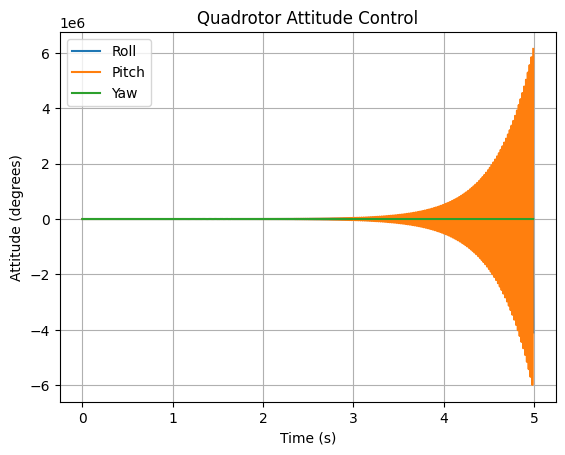

In [54]:
import numpy as np
import matplotlib.pyplot as plt

Ixx = 0.2
Iyy = 0.2
Izz = 0.4

Kp = 1.0
Ki = 0.1
Kd = 0.2

dt = 0.01
total_time = 5.0
num_steps = int(total_time / dt)

desired_roll = np.pi / 6
desired_pitch = -np.pi / 4
desired_yaw = np.pi / 3

roll = 0.0
pitch = 0.0
yaw = 0.0

error_sum = np.array([0.0, 0.0, 0.0])
prev_error = np.array([0.0, 0.0, 0.0])

time = np.arange(0.0, total_time, dt)
roll_data = []
pitch_data = []
yaw_data = []

for i in range(num_steps):

    roll_error = desired_roll - roll
    pitch_error = desired_pitch - pitch
    yaw_error = desired_yaw - yaw

    P = Kp * np.array([roll_error, pitch_error, yaw_error])
    I = Ki * error_sum
    D = Kd * (np.array([roll_error, pitch_error, yaw_error]) - prev_error) / dt

    control_output = P + I + D

    roll_accel = control_output[0] / Ixx
    pitch_accel = control_output[1] / Iyy
    yaw_accel = control_output[2] / Izz

    roll += roll_accel * dt
    pitch += pitch_accel * dt
    yaw += yaw_accel * dt

    error_sum += np.array([roll_error, pitch_error, yaw_error]) * dt
    prev_error = np.array([roll_error, pitch_error, yaw_error])

    roll_data.append(roll)
    pitch_data.append(pitch)
    yaw_data.append(yaw)

# Plotting the results
plt.figure()
plt.plot(time, np.degrees(roll_data), label='Roll')
plt.plot(time, np.degrees(pitch_data), label='Pitch')
plt.plot(time, np.degrees(yaw_data), label='Yaw')
plt.xlabel('Time (s)')
plt.ylabel('Attitude (degrees)')
plt.title('Quadrotor Attitude Control')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
class PIDController:
    def __init__(self, kp, ki, kd):
        self.kp = kp  # Proportional gain
        self.ki = ki  # Integral gain
        self.kd = kd  # Derivative gain

        self.error_integral = 0.0  # Accumulated error for the integral term
        self.previous_error = 0.0  # Error at the previous time step

    def calculate_control_output(self, error, dt):
        # Proportional term
        p_term = self.kp * error

        # Integral term
        self.error_integral += error * dt
        i_term = self.ki * self.error_integral

        # Derivative term
        d_term = self.kd * (error - self.previous_error) / dt
        self.previous_error = error

        # Total control output
        control_output = p_term + i_term + d_term

        return control_output


[[ 5.49778714e-01 -8.24668072e-01  5.49778714e-01]
 [-1.28281700e-03  1.92422550e-03  2.87351008e-01]
 [ 5.76047665e-01 -8.64071497e-01  4.37599640e-01]
 ...
 [-6.79857097e+04  1.01978565e+05  1.07703856e+00]
 [ 6.97068093e+04 -1.04560214e+05  1.07701113e+00]
 [-7.14693028e+04  1.07203954e+05  1.07698366e+00]]


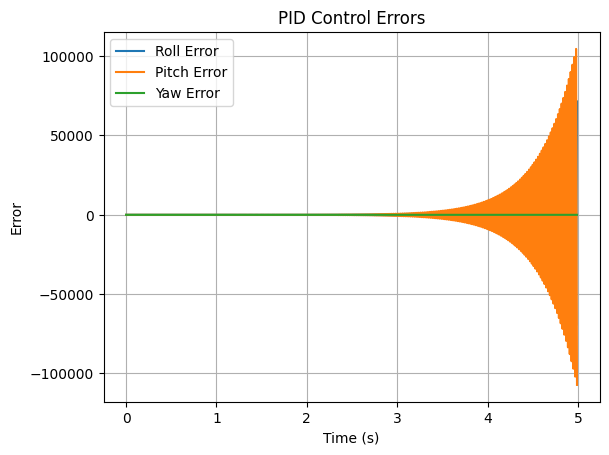

Settling Time: 1.31 s
Overshoot: 0.73 rad


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Define a class for the PID Controller
class PIDController:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.error_integral = 0.0
        self.previous_error = 0.0

    def calculate_control_output(self, error, dt):
        p_term = self.kp * error
        self.error_integral += error * dt
        i_term = self.ki * self.error_integral
        d_term = self.kd * (error - self.previous_error) / dt
        self.previous_error = error
        control_output = p_term + i_term + d_term
        return control_output

# Load data from the previous simulation
time = np.arange(0.0, total_time, dt)
roll_data = np.array(roll_data)
pitch_data = np.array(pitch_data)
yaw_data = np.array(yaw_data)

# Combine the attitude data into a single array
attitude_data = np.column_stack((roll_data, pitch_data, yaw_data))

# Define PID gains
Kp = 1.0
Ki = 0.1
Kd = 0.2

# Create an instance of the PID controller
pid_controller = PIDController(Kp, Ki, Kd)

# Print the attitude data
print(attitude_data)

# Calculate the control errors
roll_error = desired_roll - roll_data
pitch_error = desired_pitch - pitch_data
yaw_error = desired_yaw - yaw_data

# Plot the control errors
plt.figure()
plt.plot(time, roll_error, label='Roll Error')
plt.plot(time, pitch_error, label='Pitch Error')
plt.plot(time, yaw_error, label='Yaw Error')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.title('PID Control Errors')
plt.legend()
plt.grid(True)
plt.show()

# Calculate settling time and overshoot
settling_time = 0.0
overshoot = 0.0

# Find settling time
tolerance = 0.05  # Tolerance for settling time (adjust as needed)
for t, error in zip(time, yaw_error):
    if np.abs(error) <= tolerance:
        settling_time = t
        break

# Find overshoot
max_error = np.max(np.abs(yaw_error))
overshoot = max_error - np.abs(yaw_error[-1])

print(f"Settling Time: {settling_time:.2f} s")
print(f"Overshoot: {overshoot:.2f} rad")

# Analyze stability and oscillations
# Stability analysis and oscillation detection
def analyze_stability(roll_data, pitch_data, yaw_data):
    oscillation_threshold = 0.05
    instability_threshold = 10.0
    roll_oscillation_threshold = 0.1
    pitch_oscillation_threshold = 0.1

    oscillation_detected = any(abs(np.diff(data)) > oscillation_threshold for data in [roll_data, pitch_data, yaw_data])
    instability_detected = any(abs(np.diff(data)) > instability_threshold for data in [roll_data, pitch_data, yaw_data])
    roll_oscillation_detected = any(abs(np.diff(roll_data)) > roll_oscillation_threshold)
    pitch_oscillation_detected = any(abs(np.diff(pitch_data)) > pitch_oscillation_threshold)

    if oscillation_detected:
        print("Sustained oscillations detected")
    else:
        print("No sustained oscillations detected")

    if instability_detected:
        print("Instability detected")
    else:
        print("No instability detected")

    if roll_oscillation_detected:
        print("Roll oscillations detected")
    else:
        print("No roll oscillations detected")

    if pitch_oscillation_detected:
        print("Pitch oscillations detected")
    else:
        print("No pitch oscillations detected")

# Call the stability analysis function
analyze_stability(roll_data, pitch_data, yaw_data)

# Tune the PID gains (if necessary)
# PID gain tuning using Ziegler-Nichols method
def tune_pid_gains(roll_data, pitch_data, yaw_data, time):
    ultimate_gain = np.max(np.abs(yaw_data))
    oscillation_period = time[np.argmax(np.abs(yaw_data))] * 2.0

    Kp = 0.6 * ultimate_gain
    Ki = 2.0 * Kp / oscillation_period
    Kd = 0.125 * Kp * oscillation_period

    return Kp, Ki, Kd

# Call the PID gain tuning function
Kp, Ki, Kd = tune_pid_gains(roll_data, pitch_data, yaw_data, time)
print(f"Tuned PID Gains - Kp: {Kp}, Ki: {Ki}, Kd: {Kd}")

# Repeat the simulation with the tuned gains (if


#Task#4

Derive a specialization of the controller develoed in Task#3 for the problem of stabilzing the twin rotor setup in the lab.

In [61]:
def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=np.array([[1,0,0],[0,1,0],[0,0,1]])
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI)
  fu=-fe+np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;

  return dXc

In [64]:
PendulumDimensions={'l':1,'w':1,'h':15,'xp':0.25,'yp':0.25,'zp':0,};
parameters={'CM':np.array([PendulumDimensions['l']/2-PendulumDimensions['xp'],PendulumDimensions['w']/2-PendulumDimensions['yp'],PendulumDimensions['h']/2-PendulumDimensions['zp']]), 'g':1, 'M':1, 'II':np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])};
ICR = find_R(np.pi/30,np.pi/30,0)
ICOmega=np.array([0.,0.,0.]); ICo=np.array([0.,0.,0.]); ICp=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],ICOmega,ICp,ICXC]

In [65]:
Pendulum=mr.simulating_a_cube(0.1, 100., PendulumDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(Pendulum,'FULLY ACTUATED CUBOID PIVOTED AT EDGE')

#Task#5

 Experimentally verify the stability properties of the controller derived in Task#5 using the experimental setup available in the applied mechanics lab.